In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.image as mpimg

2024-12-11 18:41:13.491151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_extensions = {'.jpg', '.jpeg', '.png'}

In [3]:
working_dir = os.getcwd()
base_dir = os.path.join(working_dir, "All_Data_Fixed")
classes = os.listdir(base_dir)
classes

['Without_Peter_All_fixed', '.DS_Store', 'With_Peter_All_fixed']

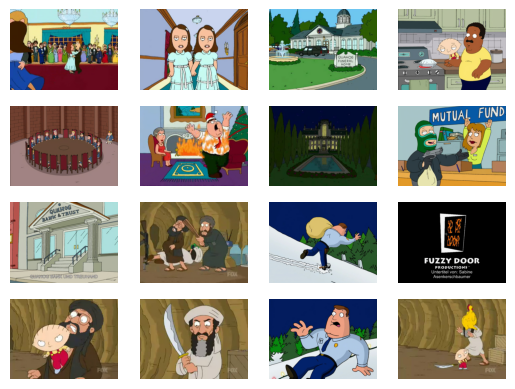

In [5]:
fig = plt.gcf()

with_dir = os.path.join('All_Data_Fixed/With_Peter_All_fixed')
without_dir = os.path.join('All_Data_Fixed/Without_Peter_All_fixed')
with_names = os.listdir(with_dir)
without_names = os.listdir(without_dir)

pic_index = 100

with_images = [os.path.join(with_dir, fname)
              for fname in with_dir[pic_index-16:pic_index]]
without_images = [os.path.join(without_dir, fname)
              for fname in without_names[pic_index-16:pic_index]]

for i, img_path in enumerate(with_images + without_images):
    sp = plt.subplot(4, 4, i+1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [6]:
# Create datasets
train_datagen = image_dataset_from_directory(base_dir,
                                                  image_size=(320,240),
                                                  subset='training',
                                                  seed = 1,
                                                  validation_split=0.1,
                                                  batch_size= 32)
test_datagen = image_dataset_from_directory(base_dir,
                                                  image_size=(320,240),
                                                  subset='validation',
                                                  seed = 1,
                                                  validation_split=0.1,
                                                  batch_size= 32)

Found 1807 files belonging to 2 classes.
Using 1627 files for training.
Found 1807 files belonging to 2 classes.
Using 180 files for validation.


In [7]:
def preprocess_dataset(image, label):
    image = preprocess_input(image)
    return image, label

# Preprocess datasets using the custom function
train_datagen = train_datagen.map(preprocess_dataset)
test_datagen = test_datagen.map(preprocess_dataset)

In [8]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(320, 240, 3))
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 10, 8, 1280)    │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,788 (16.70 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [10]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
history = model.fit(train_datagen,
          epochs=10,
          validation_data=test_datagen)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - accuracy: 0.6602 - loss: 0.6378 - val_accuracy: 0.5833 - val_loss: 0.7151
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 434ms/step - accuracy: 0.7972 - loss: 0.4176 - val_accuracy: 0.7389 - val_loss: 0.4857
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 449ms/step - accuracy: 0.8498 - loss: 0.3526 - val_accuracy: 0.8222 - val_loss: 0.4044
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - accuracy: 0.8627 - loss: 0.3108 - val_accuracy: 0.8278 - val_loss: 0.3686
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 490ms/step - accuracy: 0.8891 - loss: 0.2837 - val_accuracy: 0.8111 - val_loss: 0.4075
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 523ms/step - accuracy: 0.8804 - loss: 0.2774 - val_accuracy: 0.8389 - val_loss: 0.3735
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 511ms/step - accuracy: 0.9033 - loss: 0.2538 - val_accuracy: 0.8444 - val_loss: 0.3361
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 520ms/step - accuracy: 0.9012 - loss: 0.2417 - val_accu

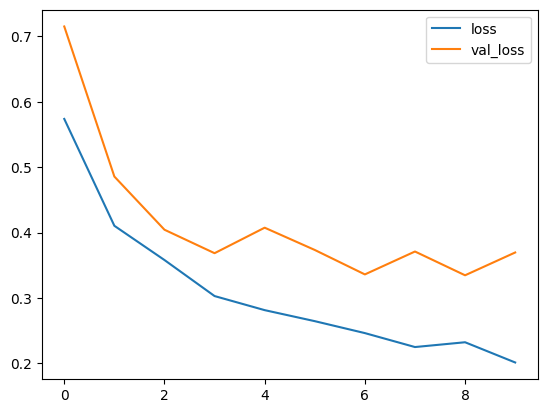

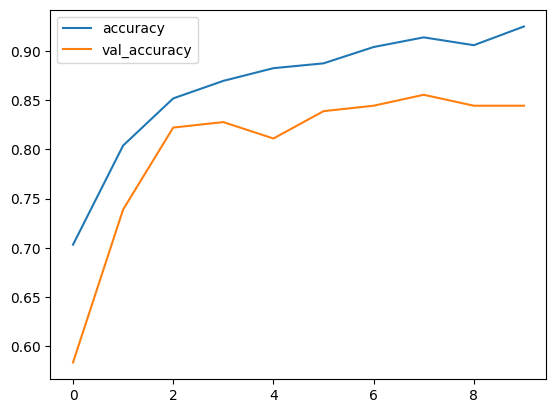

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
Without Peter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
With Peter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Without Peter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Without Peter


FileNotFoundError: [Errno 2] No such file or directory: 'All_Data_Fixed/With_Peter_All_fixed/S1E05_105.jpg'

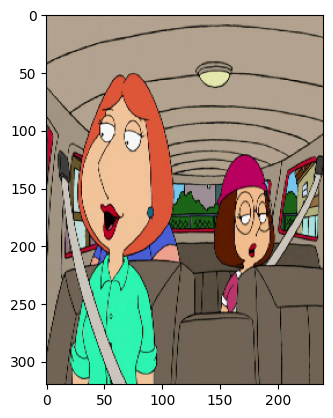

In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_image1_path = os.path.join(working_dir, "initial_model_test/S1E05_500.jpg")
test_image2_path = os.path.join(working_dir, "initial_model_test/S1E05_1000.jpg")
test_image3_path = os.path.join(working_dir, "initial_model_test/S1E05_1500.jpg")
test_image4_path = os.path.join(working_dir, "initial_model_test/S1E05_2000.jpg")
test_image5_path = os.path.join(with_dir, "S1E05_105.jpg")
test_image6_path = os.path.join(without_dir, "S1E05_7.jpg")

image_paths = [test_image1_path, 
               test_image2_path, 
               test_image3_path, 
               test_image4_path, 
               test_image5_path, 
               test_image6_path]
#Input image
for i in range(len(image_paths)):
    test_image = load_img(image_paths[i],target_size=(320,240))
    
    #For show image
    plt.imshow(test_image)
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis=0)
    
    # Result array
    result = model.predict(test_image)
    
    #Mapping result array with the main name list
    i=0
    if(result<=0.5):
      print("With Peter")
    else:
      print("Without Peter")

1/1 [==============================] - 0s 43ms/step
With Peter


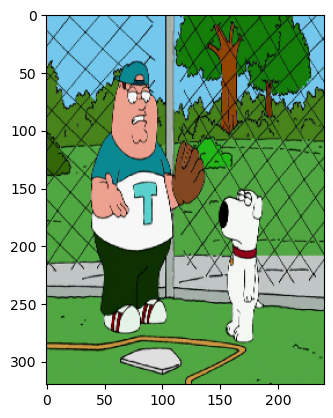

In [13]:
test_image = load_img(test_image1_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")

1/1 [==============================] - 0s 43ms/step
With Peter


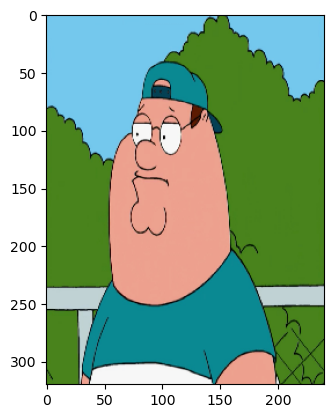

In [14]:
test_image = load_img(test_image2_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")

1/1 [==============================] - 0s 62ms/step
Without Peter


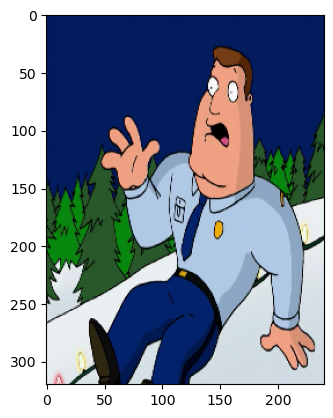

In [15]:
test_image = load_img(test_image3_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")

1/1 [==============================] - 0s 87ms/step
Without Peter


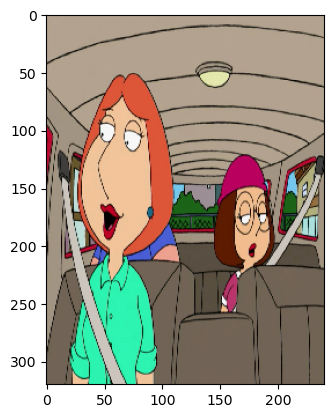

In [16]:
test_image = load_img(test_image4_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")

1/1 [==============================] - 0s 40ms/step
With Peter


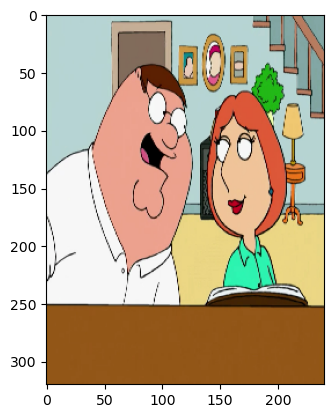

In [17]:
test_image = load_img(test_image5_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")

1/1 [==============================] - 0s 41ms/step
Without Peter


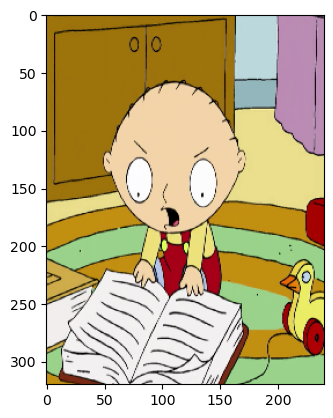

In [18]:
test_image = load_img(test_image6_path,target_size=(320,240))

#For show image
plt.imshow(test_image)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

# Result array
result = model.predict(test_image)

#Mapping result array with the main name list
i=0
if(result<=0.5):
    print("With Peter")
else:
    print("Without Peter")

In [28]:
tp = 0 
fp = 0 
tn = 0 
fn = 0  

for images, labels in test_datagen:
    preds = model.predict(images)
    # threshold=0.5
    binary_preds = (preds > 0.5).astype(int).flatten()
    labels = labels.numpy().flatten()
    
    for pred, true_label in zip(binary_preds, labels):
        if pred == 1 and true_label == 1:
            tp += 1  # Correctly predicted 'With Peter'
        elif pred == 1 and true_label == 0:
            fp += 1  # Incorrectly predicted 'With Peter'
        elif pred == 0 and true_label == 0:
            tn += 1  # Correctly predicted 'Without Peter'
        elif pred == 0 and true_label == 1:
            fn += 1  # Incorrectly predicted 'Without Peter'

# Print results
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
True Positives (TP): 102
False Positives (FP): 20
True Negatives (TN): 50
False Negatives (FN): 8


2024-12-07 18:18:00.662402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
directory = "frames_resized"

files = [f for f in os.listdir(directory) if f.startswith("out-") and f.endswith(".jpg")]

sorted_files = sorted(files, key=lambda x: int(x.split('-')[1].split('.')[0]))

In [30]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

classified = []

index = 0
for file in sorted_files:
    file_path = os.path.join(directory, file)
    test_image = load_img(file_path,target_size=(320,240))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis=0)
    result = model.predict(test_image,verbose=0)
    if(result<0.5):
        peter = 1
    else:
        peter = 0
    classified.append(peter)
    #if(index<100):
        #print(file,peter)
    index += 1

In [31]:
print(classified)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [3]:
directory = "/Users/jaewon/Documents/CSE151A/Milestone5/frames_classified/With_Peter"

files = [f for f in os.listdir(directory) if f.startswith("out-") and f.endswith(".jpg")]

classified_actual = [0 for _ in range(len(classified))] 

for file in files:
    integer_part = int(file.split('-')[1].split('.')[0])
    integer_part = int(integer_part/10)
    classified_actual[integer_part] = 1

print(classified_actual)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [4]:
T = np.sum(np.array(classified) == np.array(classified_actual))
F = np.sum(np.array(classified) != np.array(classified_actual))
accuracy = T / (T+F)
print(T+F)
print(accuracy)

6540
0.8623853211009175


In [34]:
print(np.sum(np.array(classified_actual) == 1))
print(np.sum(np.array(classified_actual) == 0))

3140
3400


In [32]:
import csv
csv_filename = 'classified.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(classified) 

In [33]:
csv_filename = 'actual.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(classified_actual) 